In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#from Shape_Visualisation import draw_shape
%matplotlib inline

In [45]:
def draw_shape(a):


    septum_d,septum_s=a[0],a[1]
    dim_d,dim_s=a[2],a[3]
    wall_d,wall_s=a[4],a[5]


    # Estimate shape using  parametric eqn of ellipse
    # x = u + a cos(t) ; y = v + b sin(t)

    u=0     #x-position of the center
    v=0   #y-position of the center
    a=4 #radius on the x-axis
    b=dim_d/2   #radius on the y-axis
    indices=[]

    t_all= np.linspace(0, 2*pi, 100)
    x_all=(u+a*np.cos(t_all))[::-1]
    y_all=(v+b*np.sin(t_all))[::-1]

    
    #remove x,y coordinates where y< (dim_s/2)

    for i,(x,y) in enumerate(zip(x_all,y_all)):
        if y<=dim_s/2:
            indices+=[i]


    x=np.delete(x_all,indices)
    y=np.delete(y_all,indices)
    
    y_s=y + septum_d
    y_w= -y - wall_d
    
    
    
    # Split the ellipse into 2 (left and right)

    ys_left=y_s[:np.argmax(y_s)+1]
    xs_left=x[:np.argmax(y_s)+1]
    yw_left=y_w[:np.argmin(y_w)+1]
    xw_left=xs_left

    ys_right=y_s[np.argmax(y_s):]
    xs_right=x[np.argmax(y_s):]
    yw_right=y_w[np.argmin(y_w):]
    xw_right=xs_right
    
    # Ensure that the right side of the ellipse do not go under the straight line
    
    #print("Y coordinate of straight line:",y[-1]+ septum_s)
    #print("max of y coordinate:",np.max(ys_right))
    
    indices=np.where(ys_right< (y[-1]+ septum_s))
    indices_1=np.where(yw_right > (-y[-1]-wall_s))

    ys_right = np.delete(ys_right, indices)
    xs_right= np.delete(xs_right, indices)
    yw_right=np.delete(yw_right,indices_1)
    xw_right=np.delete(xw_right,indices_1)
    
    
    # Estimate shape of LVIDs using a horizontal line
    
    x_more=np.linspace(x[-1],6,100)
    y_more=np.linspace(y[-1],y[-1],100)
    ys_more=np.linspace(y[-1]+ septum_s,y[-1] + septum_s,100)
    yw_more=np.linspace(-y[-1]-wall_s,-y[-1] - wall_s,100)
    xs_more=np.linspace(xs_right[-1],6,100)
    xw_more=np.linspace(xw_right[-1],6,100)
    
    
    # Add all the x,y coordinates respectively

    x=np.concatenate((x,x_more),axis=None)
    y=np.concatenate((y,y_more),axis=None)
    y_s=np.concatenate((ys_left,ys_right,ys_more),axis=None)
    x_s=np.concatenate((xs_left,xs_right,xs_more),axis=None)
    y_w=np.concatenate((yw_left,yw_right,yw_more),axis=None)
    x_w=np.concatenate((xw_left,xw_right,xw_more),axis=None)
    
    # Plot the graphs

    
    plt.grid(color='lightgray',linestyle='--')
    plt.xlim(-4, 6)
    plt.ylim(-4, 4)
    plt.plot(x,y)
    plt.plot(x,-y)
    plt.plot(x_s,y_s)
    plt.plot(x_w,y_w)
    
    plt.show()

In [46]:
df=pd.read_csv("urop.csv")


# extract healthy echo data
df = df.drop(["IDshort",'SERNO','HistoCode'], 1)
mask=df["Cardiac_Category (0=good; 1=poor)"]==0
healthy_df=df[mask]
echo=healthy_df.iloc[:,19:55]

# fill in missing data
for col in echo.columns:
    echo[col].fillna(echo[col].mean(),inplace=True)

    
# data that form part of cardiac geometry    
left_ventricle=echo.iloc[:,1:7]
aorta=echo.iloc[:,8:9]
left_atrium=echo.iloc[:,9:10]
sinus=echo.iloc[:,-4:-2]

In [47]:
# Step 1 : Standardize/normalise the data

from sklearn.preprocessing import StandardScaler

In [48]:
norm_lv=StandardScaler().fit_transform(left_ventricle)

In [49]:
# Check if data is normalized

np.mean(norm_lv) , np.std(norm_lv)

(-4.3175339846533865e-16, 1.0)

In [50]:
# Visualisation of standardized data

lv_df=pd.DataFrame(norm_lv,columns=left_ventricle.columns)
lv_df.head(3)

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,-0.674031,-1.301265,-0.641467,0.520507,-1.043695,-1.148882
1,1.899542,1.506259,2.934855,3.127819,2.881844,0.994111
2,-0.674031,0.102497,-0.130564,-0.081180,0.264818,-0.434551


In [51]:
from sklearn.decomposition import PCA
from math import pi

In [52]:
# Apply PCA on normalised dataset


class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
        
    def transform(self, x):
        return np.dot(x - self.mean, self.projection_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean
    
    def fit(self, x):
        if self.no_of_components is None:
            self.no_of_components = x.shape[1]
        else:
            self.no_of_components = self.no_of_components
            
            
        self.mean = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_components = np.argsort(self.eigen_values)[::-1]
        
        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]
        self.explained_variance = self.eigen_values[self.sorted_components[:self.no_of_components]]
        self.explained_variance_ratio = self.explained_variance / self.eigen_values.sum()

In [53]:
# Check how many components are required to retain 98% variance

pca=PCA(0.98)
pca_lv=pca.fit_transform(norm_lv)
pca.n_components_

5

In [54]:
# Create PCA with 6 components
pca=convers_pca(no_of_components=5)
pca.fit(norm_lv)

In [55]:
ratio=pca.explained_variance_ratio
ratio*100

array([46.3866596 , 24.03815879, 14.14879355,  8.93545317,  5.21814907])

In [56]:
# x = x_m + Pb
# x_m --> mean 
# P   --> t eigenvectors (p1|p2|....|pt)
# b   --> t vectors of weights (b1|b2|....|bt)T ,  -3 sqrt(lambda) < b_i < 3 sqrt(lambda)

x_m=np.array(left_ventricle.mean())


In [57]:
p=pca.projection_matrix.T
p

array([[ 0.43628661,  0.33598798,  0.08492495,  0.6192987 ,  0.55264177],
       [ 0.38193949,  0.20038955,  0.74563822, -0.10499724, -0.4075682 ],
       [ 0.44661761, -0.48663089,  0.20189803, -0.22927718,  0.13916162],
       [ 0.30545245, -0.68643438, -0.15048703,  0.13770111,  0.07286315],
       [ 0.45530431,  0.14124868, -0.52274582,  0.24036378, -0.64202042],
       [ 0.40460564,  0.3449683 , -0.31644753, -0.69002923,  0.30267148]])

In [145]:
b=pca.explained_variance
lower_limit=-0.5*np.sqrt(b)
upper_limit=.5*np.sqrt(b)

In [146]:
#adjust 1st mode, set all other paramters to zero

b1_low=np.concatenate((lower_limit[0],np.zeros(4)),axis=None).T
b1_high=np.concatenate((upper_limit[0],np.zeros(4)),axis=None).T
b2_low=np.concatenate((np.zeros(1),lower_limit[1],np.zeros(3)),axis=None).T
b2_high=np.concatenate((np.zeros(1),upper_limit[1],np.zeros(3)),axis=None).T
b3_low=np.concatenate((np.zeros(2),lower_limit[1],np.zeros(2)),axis=None).T
b3_high=np.concatenate((np.zeros(2),upper_limit[1],np.zeros(2)),axis=None).T

In [147]:
p

array([[ 0.43628661,  0.33598798,  0.08492495,  0.6192987 ,  0.55264177],
       [ 0.38193949,  0.20038955,  0.74563822, -0.10499724, -0.4075682 ],
       [ 0.44661761, -0.48663089,  0.20189803, -0.22927718,  0.13916162],
       [ 0.30545245, -0.68643438, -0.15048703,  0.13770111,  0.07286315],
       [ 0.45530431,  0.14124868, -0.52274582,  0.24036378, -0.64202042],
       [ 0.40460564,  0.3449683 , -0.31644753, -0.69002923,  0.30267148]])

In [131]:

b1_low


array([-1.68851488,  0.        ,  0.        ,  0.        ,  0.        ])

In [132]:
x1_low

array([0.41023321, 0.85563999, 3.99960643, 2.18259569, 0.37512976,
       1.08007535])

In [148]:
x1_low=x_m+ np.matmul(p,b1_low)
x1_high=x_m+ np.matmul(p,b1_high)
x2_low=x_m+ np.matmul(p,b2_low)
x2_high=x_m+ np.matmul(p,b2_high)
x3_low=x_m+ np.matmul(p,b3_low)
x3_high=x_m+ np.matmul(p,b3_high)

In [134]:
left_ventricle

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
3,0.7,0.90,4.00,2.7,0.6,1.10
7,1.0,1.50,6.10,4.0,1.2,1.70
12,0.7,1.20,4.30,2.4,0.8,1.30
14,0.8,1.40,4.30,1.9,0.7,1.30
15,0.7,0.90,5.00,3.2,0.9,1.60
17,0.7,1.20,3.60,2.0,0.7,1.30
20,0.8,1.30,4.90,2.8,0.7,1.50
22,0.7,1.00,3.90,2.4,0.7,1.30
23,0.7,1.00,3.60,2.2,0.8,1.00
24,0.7,1.00,4.20,2.6,0.7,1.30


In [135]:

x1=pd.DataFrame(np.round(x1_low,2).reshape(-1,6),columns=left_ventricle.columns) 
x2=pd.DataFrame(np.round(x_m,2).reshape(-1,6),columns=left_ventricle.columns) 
x3=pd.DataFrame(np.round(x1_high,2).reshape(-1,6),columns=left_ventricle.columns)

In [136]:
x1

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,0.04,0.53,3.62,1.92,-0.01,0.74


In [137]:
x2

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,0.78,1.18,4.38,2.44,0.76,1.42


In [138]:
x3

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,1.52,1.82,5.13,2.96,1.53,2.1


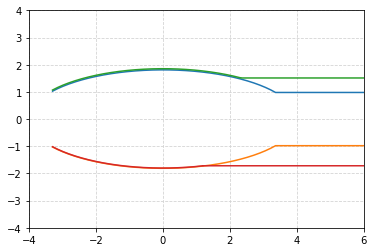

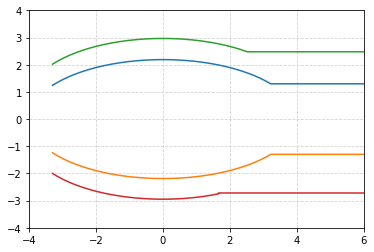

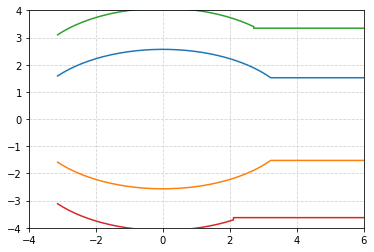

(None, None, None)

In [139]:
# Adjusting PC1

draw_shape(x1_low),draw_shape(x_m),draw_shape(x1_high)

In [114]:
df["IVSD__cm"].max()

1.5

In [115]:
x2_low,x_m,x2_high

(array([0.3701743 , 0.93451951, 4.96817194, 3.27484483, 0.58783447,
        1.00235385]),
 array([0.77857143, 1.17809524, 4.37666667, 2.44047619, 0.75952381,
        1.42166667]),
 array([1.18696856, 1.42167096, 3.7851614 , 1.60610755, 0.93121315,
        1.84097948]))

In [123]:

x1=pd.DataFrame(np.round(x2_low,2).reshape(-1,6),columns=left_ventricle.columns) 
x2=pd.DataFrame(np.round(x_m,2).reshape(-1,6),columns=left_ventricle.columns) 
x3=pd.DataFrame(np.round(x2_high,2).reshape(-1,6),columns=left_ventricle.columns)

In [124]:
x1

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,0.57,1.06,4.67,2.86,0.67,1.21


In [125]:
x3

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,0.98,1.3,4.08,2.02,0.85,1.63


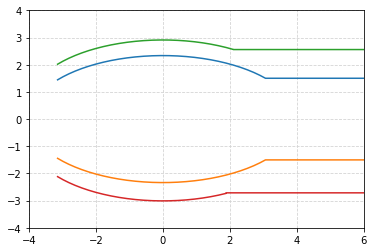

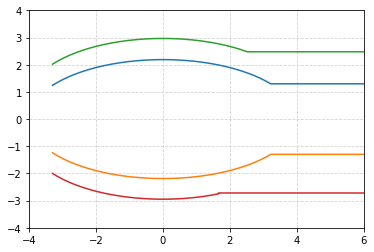

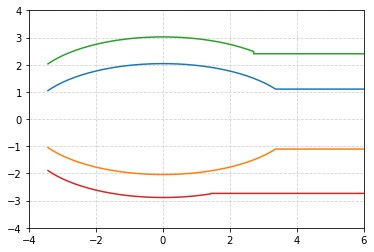

(None, None, None)

In [149]:
#Adjusting PC2
draw_shape(x2_low),draw_shape(x_m),draw_shape(x2_high)

In [73]:
x3_low,x_m,x3_high

(array([0.72695782, 0.72492946, 4.25396202, 2.53193552, 1.07722549,
        1.61398942]),
 array([0.77857143, 1.17809524, 4.37666667, 2.44047619, 0.75952381,
        1.42166667]),
 array([0.83018504, 1.63126102, 4.49937132, 2.34901686, 0.44182212,
        1.22934392]))

In [74]:
left_ventricle.head()

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
3,0.7,0.9,4.0,2.7,0.6,1.1
7,1.0,1.5,6.1,4.0,1.2,1.7
12,0.7,1.2,4.3,2.4,0.8,1.3
14,0.8,1.4,4.3,1.9,0.7,1.3
15,0.7,0.9,5.0,3.2,0.9,1.6


In [150]:
x1=pd.DataFrame(np.round(x3_low,2).reshape(-1,6),columns=left_ventricle.columns) 
x3=pd.DataFrame(np.round(x3_high,2).reshape(-1,6),columns=left_ventricle.columns)

In [151]:
x1

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,0.73,0.72,4.25,2.53,1.08,1.61


In [152]:
x3

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm
0,0.83,1.63,4.5,2.35,0.44,1.23


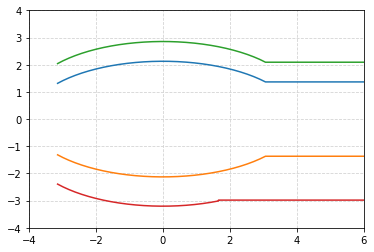

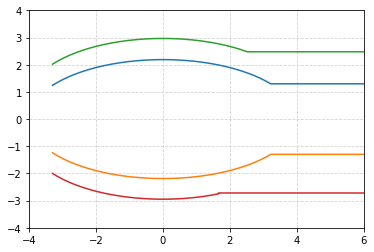

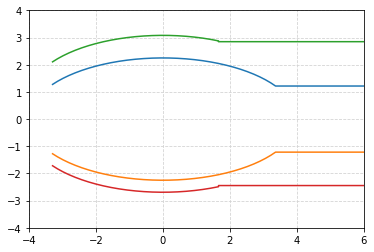

(None, None, None)

In [153]:
draw_shape(x3_low),draw_shape(x_m),draw_shape(x3_high)